# Introduction


**ASSIGNMENT DEADLINE: 19 Oct 2019 17:00**

In this assignemnt, the task is to implement some basic components for training convolutional neural network (CNN) over the MNIST dataset and recurrent neural network (RNN) over the NLTK dataset. You need to follow the lecture notes to 
- implement the RMSProp algorithm in nn/optimizers.py
- implement multiple operations in nn/operators.py, which are used by the layers (in nn/layer.py)
- implement the forward function of Bi-directional RNN (in nn/layer.py)
- tune the model architecture and some hyperparameters to improve the accuracy.

**Attention**:
- To run this Jupyter notebook, you need to install the dependent libraries as stated in [README.MD](README.MD). You do not need and should not use other libraries (like tensorflow and pytorch) in your code. The major version of Python should be 3.
- You do not need a GPU for this assignment. CPU is enough.
- Before you finish the implementation of the required functions, if you run this notebook, you may see errors.
- Do not change the signature (the name and arguments) of the existing functions in the repository ; otherwise your implementation cannot be tested correctly and you will get penalty.
- Do not change the structure of files in the repository (e.g., adding, renaming or deleting any files); otherwise your implementation cannot be tested correctly and you will get penalty.
- You can add functions in the existing files, but you should not change the import statements (e.g., adding a new import statement). For example, if you want to implement a function foo(), you can implement it inside operator.py and call it; but you cannot implement it in another file and import that file in operators.py. Otherwise your implementation cannot be tested correctly and you will get penalty.
- After you implement one function, remember to restart the notebook kernel to help it recognize your fresh code.

## Structure of the Repository

The structure of this repository is shown as below:

```bash
codes/
    data/
        datasets.py     # load dataset, like MNIST
        mnist.npz       # mnist dataset 
        corpus.csv      # for nltk dataset 
        dictionary.csv  # for nltk dataset
    models/             # example models of your tiny deep learning framework
        MNISTNet.py     # example model on MNIST dataset
        SentimentNet.py # example model on nltk dataset
    nn/                 # components of neural networks
        operators.py    # operators; **You need to edit this file to add missing code**
        optimizers.py   # optimizing methods; **You need to implement the RMSprop algorithm**
        layers.py       # layer abstract for CNN and RNN
        loss.py         # loss function for optimization
        model.py        # model abstraction for defining and training models
        initializers.py # initializing methods to initialize parameters (like weights, bias)
        funtional.py    # some helpful function during implementation of training
    utils/              # some additional tools for CNN
        check_grads_cnn.py  # for CNN, help you check your forward function and backward function
        check_grads_rnn.py  # for RNN, help you check your forward function and backward function
        tools.py        # other useful functions for testing the codes
    main.ipynb          # this notebook which calls the functions in other modules/files
    README.MD           # list of dependent libraries
```

## Functionality of This Notebook

This iPython notebook serves to:

- explain code structure, main APIs
- explain your implementation task and tuning task
- provide code to test your implemented forward and backward function for different operations
- provide related materials to help you understand the implementation of some operations and optimizers

*You can type `jupyter lab` in the terminal to start this jupyter notebook when your current working directory is cs5242. It's much more convinient than jupyter notebook.*

# Your Task on CNN

## Base Classes

In [nn/optimizers.py](nn/optimizers.py), we define the base optimizer class. We have also implemented SGD, Adagrad, Adam for you. **You only need to implement the RMSprop optimizer in the [nn/optimizers.py](nn/optimizers.py) following the same style.**

```python
class Optimizer():

    def __init__(self, lr):
        """Initialization

        # Arguments
            lr: float, learnig rate 
        """
        self.lr = lr

    def update(self, x, x_grad, iteration):
        """Update parameters with gradients"""
        raise NotImplementedError

    def sheduler(self, func, iteration):
        """learning rate sheduler, to change learning rate with respect to iteration

        # Arguments
            func: function, arguments are lr and iteration
            iteration: int, current iteration number in the whole training process (not in that epoch)

        # Returns
            lr: float, the new learning rate
        """
        lr = func(self.lr, iteration)
        return lr
```



In [nn/operators.py](nn/operators.py), we define the base operator class and have implemented some operations (like relu, flatten, linear) for you. **You only need to implement the rest operations in the [nn/operators.py](nn/operators.py) following the same style.

```python
class operator(object):
    """
    operator abstraction
    """

    def forward(self, input):
        """Forward operation, reture output"""
        raise NotImplementedError

    def backward(self, out_grad, input):
        """Backward operation, return gradient to input"""
        raise NotImplementedError
```



## RMSprop Optimizer
In the file [nn/optimizers.py](nn/optimizers.py), there are 4 types of optimizer (`SGD`, `Adam`, `RMSprop` and `Adagrad`). **You only need to implement the `update` function of `RMSprop`**. 

`RMSprop` optimizer is initialized like this:

```python
class RMSprop(Optimizer):
    def __init__(self, lr=0.001, bata=0.9, epsilon=None, decay=0, sheduler_func=None):
        super(RMSprop, self).__init__(lr)
        self.bata = bata
        self.epsilon = epsilon
        self.decay = decay
        if not self.epsilon:
            self.epsilon = 1e-8
        self.accumulators = None
        self.sheduler_func = sheduler_func
```

- `lr`: The initial learning rate.
- `beta`: The weight of moving average for second moment of gradient
- `decay`: The learning rate decay ratio
- `sheduler_func`: Function to change learning rate with respect to iterations

More details can be found in the slides. 

## Covolution Layer

Conv2D (in [nn/layers.py](nn/layers.py)) implements the Convolution layer. It maintains the weight matrix and bias vector, and calls the forward and backward funtion of `conv` class in [nn/operators.py](nn/operators.py) to do the real operations. 


```python
class Conv2D(Layer):
    def __init__(self, conv_params, initializer=Gaussian(), name='conv'):
        super(Conv2D, self).__init__(name=name)
        self.conv_params = conv_params
        self.conv = conv(conv_params)

        self.trainable = True

        self.weights = initializer.initialize(
            (conv_params['out_channel'], conv_params['in_channel'], conv_params['kernel_h'], conv_params['kernel_w']))
        self.bias = np.zeros((conv_params['out_channel']))

        self.w_grad = np.zeros(self.weights.shape)
        self.b_grad = np.zeros(self.bias.shape)

    def forward(self, input):
        output = self.conv.forward(input, self.weights, self.bias)
        return output

    def backward(self, out_grad, input):
        in_grad, self.w_grad, self.b_grad = self.conv.backward(
            out_grad, input, self.weights, self.bias)
        return in_grad

```

`conv_params` is a dictionary, containing these parameters:

- 'kernel_h': The height of kernel.
- 'kernel_w': The width of kernel.
- 'stride': The number of pixels between adjacent receptive fields in the horizontal and vertical directions.
- 'pad': The number of pixels padded to the bottom, top, left and right of each feature map. **Here pad=2 means adding 2 zeros to the left, right, top and bottom respectively**.
- 'in_channel': The number of input channels.
- 'out_channel': The number of output channels.

`initializer` is an instance of Initializer class, used to initialize parameters


### Forward Function of Conv Operator

You need to implement the forward function of the `conv` class in [nn/operators.py](nn/operators.py).

The input consists of N data points, each with C channels, height H and width W. We convolve each input with K different kernels, where each kernel has  C channels and has height HH and width WW.

**WARNING: Please implement the matrix product (img2col) method as shown in the Lecture notes. The naive  implementation is too slow for training a complete CNN model.**

You can test your implementation by restarting jupyter notebook kernel and running the following:

In [20]:
import numpy as np
import warnings
warnings.simplefilter('ignore')

from nn.layers import Conv2D
from utils.tools import rel_error

from keras import Sequential
from keras.layers import Conv2D as k_Conv2D

input = np.random.uniform(size=(10, 3, 30, 30))
params = { 
    'kernel_h': 5,
    'kernel_w': 5,
    'pad': 0,
    'stride': 2,
    'in_channel': input.shape[1],
    'out_channel': 64,
}
conv = Conv2D(params)
out = conv.forward(input)

keras_conv = Sequential([
    k_Conv2D(filters=params['out_channel'],
            kernel_size=(params['kernel_h'], params['kernel_w']),
            strides=(params['stride'], params['stride']),
            padding='valid',
            data_format='channels_first',
            input_shape=input.shape[1:]),
])
keras_conv.layers[0].set_weights([conv.weights.transpose((2,3,1,0)), conv.bias])

keras_out = keras_conv.predict(input, batch_size=input.shape[0])
print('Relative error (<1e-6 will be fine): ', rel_error(out, keras_out))

Relative error (<1e-6 will be fine):  3.349876505161958e-07


### Backward Function of Conv Operator
 
You need to implement the backward function for the `conv` class in the file [nn/operators.py](nn/operators.py). 

When you are done, restart jupyter notebook and run the following to check your backward implementation. 

In [21]:
from nn.layers import Conv2D
import numpy as np
from utils.check_grads_cnn import check_grads_layer

batch = 10
conv_params={
    'kernel_h': 3,
    'kernel_w': 3,
    'pad': 0,
    'stride': 2,
    'in_channel': 3,
    'out_channel': 10
}
in_height = 10
in_width = 20
out_height = 1+(in_height+2*conv_params['pad']-conv_params['kernel_h'])//conv_params['stride']
out_width = 1+(in_width+2*conv_params['pad']-conv_params['kernel_w'])//conv_params['stride']

input = np.random.uniform(size=(batch, conv_params['in_channel'], in_height, in_width))
out_grad = np.random.uniform(size=(batch, conv_params['out_channel'], out_height, out_width))

conv = Conv2D(conv_params)
check_grads_layer(conv, input, out_grad)

Gradient to input: correct
Gradient to weights:  correct
Gradient to bias:  correct


## Pooling Layer

Pool2D (in nn/layers.py) implements the pooling layer. It calls the forward and backward funtion of the pool class in nn/operators.py to do the real operations. 

Ihe initialization, forward and backward funtion of the class `Pooling` are shown as below:

```python
class Pool2D(Layer):
    def __init__(self, pool_params, name='pooling'):
        super(Pool2D, self).__init__(name=name)
        self.pool_params = pool_params
        self.pool = pool(pool_params)

    def forward(self, input):
        output = self.pool.forward(input)
        return output

    def backward(self, out_grad, input):
        in_grad = self.pool.backward(out_grad, input)
        return in_grad
```

`pool_params` is a dictionary, containing these parameters:
- 'pool_type': The type of pooling, 'max' or 'avg'
- 'pool_h': The height of pooling kernel.
- 'pool_w': The width of pooling kernel.
- 'stride': The number of pixels between adjacent receptive fields in the horizontal and vertical directions.
- 'pad': The number of pixels that will be used to zero-pad the input in each x-y direction. **Here pad=2 means adding 2 zeros to the left, right, top and bottom respectively**.


### Forward Function of Pool Operator

You need to implement the forward function for `pool` class in the file [nn/operators.py](nn/operators.py).

You can test your implementation by restarting jupyter notebook kernel and running the following:

In [22]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from nn.layers import Pool2D
from utils.tools import rel_error

from keras import Sequential
from keras.layers import MaxPooling2D

input = np.random.uniform(size=(10, 3, 30, 30))
params = { 
    'pool_type': 'max',
    'pool_height': 5,
    'pool_width': 5,
    'pad': 0,
    'stride': 2,
}
pool = Pool2D(params)
out = pool.forward(input)

keras_pool = Sequential([
    MaxPooling2D(pool_size=(params['pool_height'], params['pool_width']),
                 strides=params['stride'],
                 padding='valid',
                 data_format='channels_first',
                 input_shape=input.shape[1:])
])
keras_out = keras_pool.predict(input, batch_size=input.shape[0])
print('Relative error (<1e-6 will be fine): ', rel_error(out, keras_out))

Relative error (<1e-6 will be fine):  7.849888966570502e-09


## Dropout Layer

Dropout [1] is a technique for regularizing neural networks by randomly setting some neurons to zero. 

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012


The Dropout layer calls the `dropout` operator in [nn/operators.py](nn/operators.py) to do the real operations.

```python
class Dropout(Layer):
    def __init__(self, rate, name='dropout', seed=None):
        super(Dropout, self).__init__(name=name)
        self.rate = rate
        self.seed = seed
        self.dropout = dropout(rate, self.training, seed)  # create the dropout operator instance

    def forward(self, input):
        output = self.dropout.forward(input)
        return output

    def backward(self, out_grad, input):
        in_grad = self.dropout.backward(out_grad, input)
        return in_grad
```

- `rate`: The probability of setting a neuron to zero
- `seed`: seed: int, random seed to sample from input, so as to get mask, which is convenient to check gradients. But for real training, it should be None to make sure to randomly drop neurons

### Forward Function of Dropout Operator

In [nn/operators.py](nn/operators.py), you need to implement the forward function for `dropout` class. Since dropout behaves differently during training and testing, you need to consider both modes.  `p` refers to the probability of setting a neuron to zero. 

### Backward Function of Dropout Operator

In [nn/operatiors.py](nn/operators.py), you need to implement the backward function for `dropout` class. After the implementation, restart jupyter notebook and run the following cell to check your implementation.

In [23]:
from nn.layers import Dropout

import numpy as np
from utils.check_grads_cnn import check_grads_layer

rate = 0.1
batch = 2
height = 10
width = 20
channel = 10

np.random.seed(1234)
input = np.random.uniform(size=(batch, channel, height, width))
out_grads = np.random.uniform(size=(batch, channel, height, width))

dropout = Dropout(rate, seed=1234)
dropout.set_mode(True)
check_grads_layer(dropout, input, out_grads)

Gradient to input: correct


## Classification using CNNs
In this section, you are required to test your implementations above by running an ensemble NN on a MNIST dataset. The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

We have provided you with [models/MNISTNet.py](models/MNISTNet.py), which defines a CNN model for this task. By training the `MNISTNet` for one epoch, you should achieve above 85% on test set. You may have to wait about 5 minutes for training to be completed.

Number of training images:  48000
Number of validation images:  12000
Number of testing images:  10000

Four examples of training images:


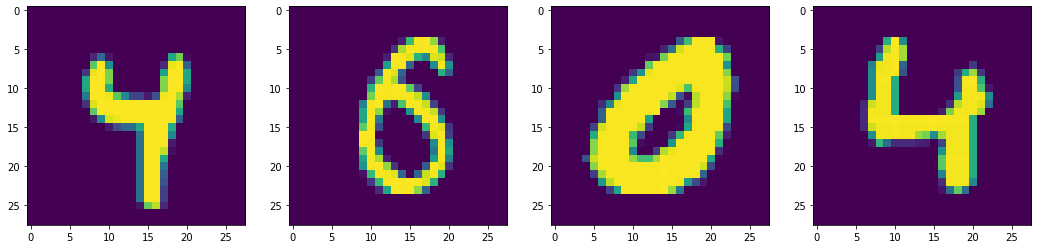

In [24]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from models.MNISTNet import MNISTNet
from nn.loss import SoftmaxCrossEntropy, L2
from nn.optimizers import Adam
from data.datasets import MNIST
np.random.seed(5242)

mnist = MNIST()
mnist.load()
idx = np.random.randint(mnist.num_train, size=4)
print('\nFour examples of training images:')
img = mnist.x_train[idx][:,0,:,:]

plt.figure(1, figsize=(18, 18))
plt.subplot(1, 4, 1)
plt.imshow(img[0])
plt.subplot(1, 4, 2)
plt.imshow(img[1])
plt.subplot(1, 4, 3)
plt.imshow(img[2])
plt.subplot(1, 4, 4)
plt.imshow(img[3])

In [ ]:
from nn.optimizers import RMSprop, Adam

model = MNISTNet()
loss = SoftmaxCrossEntropy(num_class=10)

# define your learning rate sheduler
def func(lr, iteration):
    if iteration % 1000 ==0:
        return lr*0.5
    else:
        return lr

adam = Adam(lr=0.001, decay=0,  sheduler_func=None, bias_correction=True)
l2 = L2(w=0.001) # L2 regularization with lambda=0.001
model.compile(optimizer=adam, loss=loss, regularization=l2)

import time
start = time.time()
train_results, val_results, test_results = model.train(
    mnist, 
    train_batch=50, val_batch=1000, test_batch=1000, 
    epochs=2, 
    val_intervals=-1, test_intervals=900, print_intervals=100)
print('cost:', time.time()-start)

Epoch 0: 
Train iter 100/960:	acc 0.10, loss 2.30, reg loss 0.00, speed 1093.39 samples/sec
Train iter 200/960:	acc 0.12, loss 2.27, reg loss 0.00, speed 1118.23 samples/sec
Train iter 300/960:	acc 0.68, loss 1.03, reg loss 0.02, speed 1119.61 samples/sec
Train iter 400/960:	acc 0.78, loss 0.58, reg loss 0.02, speed 1132.12 samples/sec
Train iter 500/960:	acc 0.88, loss 0.63, reg loss 0.02, speed 1114.30 samples/sec
Train iter 600/960:	acc 0.80, loss 0.58, reg loss 0.02, speed 1139.60 samples/sec


In [ ]:
plt.figure(figsize=(18, 8))
plt.subplot(2, 2, 1)
plt.title('Training loss')
plt.plot(train_results[:,0], train_results[:,1])
plt.subplot(2, 2, 3)
plt.title('Training accuracy')
plt.plot(train_results[:,0], train_results[:,2])
plt.subplot(2, 2, 2)
plt.title('Testing loss')
plt.plot(test_results[:,0], test_results[:, 1])
plt.subplot(2, 2, 4)
plt.title('Testing accuracy')
plt.plot(test_results[:, 0], test_results[:,2])

### Train your best MNISTNet!
Tweak the hyperparameters and structure of the MNISTNet. The network is small, hence the training should finish quickly using your CPU (less than 1 hour). 

The following cell should include your model e.g., `class MyModel` (similar to MNISTNet), the training and validation code. You just need to include the model with the best performance. When you submit, the execution results (output of the cell) should be kept.

In [ ]:
# Implement your new model; and do the training and validation following the previous cell. 
# ...


# Your Task on RNN

## GRU


The GRU layer calls the forward and backward functions of the gru operator in [nn/operators.py](nn/operators.py) to do the real operation.

You need to implement the forward and backward function of the `gru` operator

```python
class GRU(Layer):
    def __init__(self, in_features, units, h0=None, name='gru', initializer=Gaussian()):
        """
        # Arguments
            in_features: int, the number of input features
            units: int, the number of hidden units
            h0: default initial state, numpy array with shape (units,)
        """
        super(GRU, self).__init__(name=name)
        self.trainable = True
        self.cell = gru()  # it's operation instead of layer

        self.kernel = initializer.initialize((in_features, 3 * units))
        self.recurrent_kernel = initializer.initialize((units, 3 * units))

        if h0 is None:
            self.h0 = np.zeros(units)
        else:
            self.h0 = h0

        self.kernel_grad = np.zeros(self.kernel.shape)
        self.r_kernel_grad = np.zeros(self.recurrent_kernel.shape)
```


### Forward Function of GRU Operator

In the file [nn/operators.py](nn/operators.py), implement the forward function for `gru` operation. (`input` is a list of two numpy arrays, `[x, h]`). 

The following cell test the implementation.

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import keras
from keras import layers
from nn.layers import GRUCell
from utils.tools import rel_error

N, D, H = 3, 10, 4
x = np.random.uniform(size=(N, D))
prev_h = np.random.uniform(size=(N, H))

gru_cell = GRUCell(in_features=D, units=H)
out = gru_cell.forward([x, prev_h])
# compare with the keras implementation
keras_x = layers.Input(shape=(1, D), name='x')
keras_prev_h = layers.Input(shape=(H,), name='prev_h')
# keras_rnn = layers.RNN(layers.(H),
#                        name='rnn')(keras_x, initial_state=keras_prev_h)
keras_rnn = layers.GRU(units=H, use_bias=False, recurrent_activation='sigmoid')(keras_x, initial_state=keras_prev_h)
keras_model = keras.Model(inputs=[keras_x, keras_prev_h], 
                          outputs=keras_rnn)
keras_model.layers[2].set_weights([gru_cell.kernel,
                                   gru_cell.recurrent_kernel])
keras_out = keras_model.predict_on_batch([x[:, None, :], prev_h])

print('Relative error (<1e-5 will be fine): {}'.format(rel_error(keras_out, out)))

### Backward Function of GRU Operator

Implement the backward function for the `gru` operation in the file [nn/operators.py](nn/operators.py). 

When you are done, restart jupyter notebook and run the following cell to check your implementation

In [ ]:
import numpy as np
from nn.layers import GRUCell
from utils.check_grads_rnn import check_grads_layer

N, D, H = 3, 10, 4
x = np.random.uniform(size=(N, D))
prev_h = np.random.uniform(size=(N, H))
in_grads = np.random.uniform(size=(N, H))

gru_cell = GRUCell(in_features=D, units=H)

check_grads_layer(gru_cell, [x, prev_h], in_grads)

## Bi-directional RNN Layer

Vallina RNN operates over input sequence in one direction, so it has limitations as the future input information cannot be reached from the current state. On the contrary, Bi-directional RNN addresses this shortcoming by operating the input sequence in both forward and backward directions. 

Usually, Bi-directional RNN is implemented by running two independent RNNs in opposite direction of the input data, and concatenating the outputs of the two RNNs. The following function reverses a batch of sequence data  which is necessary for implementing Bi-directional RNN.

```python
def _reverse_temporal_data(self, x, mask):
    num_nan = np.sum(~mask, axis=1)
    reversed_x = np.array(x[:, ::-1, :])
    for i in range(num_nan.size):
        reversed_x[i] = np.roll(reversed_x[i], x.shape[1]-num_nan[i], axis=0)
    return reversed_x
```

### Forward Function of Bi-directional RNN Layer

Please implement `BiRNN.forward(self, inputs)` [nn/layers.py](nn/layers.py) and use the following code for testing. Note that `H` is the dimension of the hidden states of one internal RNN, so the actual dimension of the hidden states (or outputs) of Bidirectional RNN is `2*H`.

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import keras
from keras import layers
# import importlib
# import rnn_layers
# importlib.reload(rnn_layers)
from nn.layers import BiRNN
from utils.tools import rel_error

N, T, D, H = 2, 3, 4, 5
x = np.random.uniform(size=(N, T, D))
x[0, -1:, :] = np.nan
x[1, -2:, :] = np.nan
h0 = np.random.uniform(size=(H,))
hr = np.random.uniform(size=(H,))

brnn = BiRNN(in_features=D, units=H, h0=h0, hr=hr)
out = brnn.forward(x)

keras_x = layers.Input(shape=(T, D), name='x')
keras_h0 = layers.Input(shape=(H,), name='h0')
keras_hr = layers.Input(shape=(H,), name='hr')
keras_x_masked = layers.Masking(mask_value=0.)(keras_x)
keras_rnn = layers.RNN(layers.SimpleRNNCell(H), return_sequences=True)
keras_brnn = layers.Bidirectional(keras_rnn, merge_mode='concat', name='brnn')(
        keras_x_masked, initial_state=[keras_h0, keras_hr])
keras_model = keras.Model(inputs=[keras_x, keras_h0, keras_hr],
                          outputs=keras_brnn)
keras_model.get_layer('brnn').set_weights([brnn.forward_rnn.kernel,
                                           brnn.forward_rnn.recurrent_kernel, 
                                           brnn.forward_rnn.bias,
                                           brnn.backward_rnn.kernel, 
                                           brnn.backward_rnn.recurrent_kernel,
                                           brnn.backward_rnn.bias])
keras_out = keras_model.predict_on_batch([np.nan_to_num(x), np.tile(h0, (N, 1)), np.tile(hr, (N, 1))])
nan_indices = np.where(np.any(np.isnan(x), axis=2))
keras_out[nan_indices[0], nan_indices[1], :] = np.nan

print('Relative error (<1e-5 will be fine): {}'.format(rel_error(keras_out, out)))

## Sentiment Analysis using RNNs

In this section, you need to implement a RNN model for sentiment analysis. The dataset, `data/corpus.csv`, consists of 800 real movie comments and the corresponding labels that indicate whether the comments are positive or negative. For example:
```
POSTIVE: I absolutely LOVE Harry Potter, as you can tell already.
NEGATIVE: My dad's being stupid about brokeback mountain...
```

We provide a basic model for your experiments, which can be found in [models/SentimentNet.py](models/SentimentNet.py). The architecture is as follow:

```python
Linear(vocab_size, 200, name='embedding')
BiRNN(in_features=200, units=50, initializer=Gaussian(std=0.01))
Linear(100, 32, name='linear1')
TemporalPooling()
Linear(32, 2, name='linear2')
```

The input to the network is a sequence of one-hot vectors, each of which represents a word. The 1st Linear layer works as an embedding layer. After a Bi-directional RNN layer and another Linear layer, a TemporalPooling layer (see `layers.py`) is used to aggregate the vectors into one vector, which skips `NaN`s. The rest of the network is the same as a normal classifier.

In [ ]:
from data import datasets
from models.SentimentNet import SentimentNet
from nn.loss import SoftmaxCrossEntropy, L2
from nn.optimizers import Adam
import numpy as np
np.random.seed(5242)

dataset = datasets.Sentiment()
model = SentimentNet(dataset.dictionary)
loss = SoftmaxCrossEntropy(num_class=2)

adam = Adam(lr=0.01, decay=0,
            sheduler_func=lambda lr, it: lr*0.5 if it%1000==0 else lr)
model.compile(optimizer=adam, loss=loss, regularization=L2(w=0.001))
train_results, val_results, test_results = model.train(
        dataset, 
        train_batch=20, val_batch=100, test_batch=100, 
        epochs=5, 
        val_intervals=-1, test_intervals=25, print_intervals=5)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 8))
plt.subplot(2, 2, 1)
plt.title('Training loss')
plt.plot(train_results[:,0], train_results[:,1])
plt.subplot(2, 2, 3)
plt.title('Training accuracy')
plt.plot(train_results[:,0], train_results[:,2])
plt.subplot(2, 2, 2)
plt.title('Testing loss')
plt.plot(test_results[:,0], test_results[:, 1])
plt.subplot(2, 2, 4)
plt.title('Testing accuracy')
plt.plot(test_results[:, 0], test_results[:,2])
plt.plot(test_results[:, 0], test_results[:,2])

### Train your best SentimentNet!

Tweak the hyperparameters and structure of the SentimentNet.

The following cell should include your model e.g., `class MyModel` (similar to SentimentNet), the training and validation code. You just need to include the model with the best performance. When you submit, the execution results (output of the cell) should be kept.

In [ ]:
# define your new model and all training codes here, like loading data, defining optimizer and so on

# ...


# Marking Scheme

Marking scheme is shown below:
- 3 marks for `RMSprop` update function
- 3 marks for `conv` forward function
- 3 marks for `pool` forward function
- 3 marks for `dropout` forward and backward function
- 3 marks for `gru` forward and backward function
- 3 marks for `BiRNN` forward function
- 3 marks for tuning your best MNISTNet
- 3 marks for tuning your best SentimentNet
- 1 marks for your submission format

We will run multiple test cases to check the correctness of your implementation. You may not get the full marks even if you pass the tests in this notebook as we have a few other test cases for each task, which are not included in this notebook.

For the tuning tasks, please use a fixed random seed (e.g., 0) to make sure the results are reproducible. 

As for submission format, please follow below submission instructions.

**DO NOT** use external libraries like Tensorflow, keras and Pytorch in your implementation. **DO NOT** copy the code from the internet, e.g. github. We have offered all materials that you can refer to in this notebook.

# Final submission instructions
Please submit the following:

1) Your codes in a folder named `codes`, and keep the structure of all files in this folder the same as what we have provided. 

**ASSIGNMENT DEADLINE: 19 Oct 2019 17:00**

Do not include the `data` folder. Please zip the following folders under a folder named with your NUSNET ID: eg. `a0123456g.zip` and submit the zipped folder to LumiNUS/Files/Assignment Submission. If unzip the file, the structure should be like this:

```bash
a0123456g/
    codes/
        models/
            ...
        nn/
            ...
        utils/
            ...
        main.ipynb
        README.MD
```